#### Reference:

1. https://www.kaggle.com/code/itsuki9180/a-segmentation-is-in-reverse-order
1. https://www.kaggle.com/code/samuelcortinhas/rnsa-3d-model-train-pytorch
1. https://www.kaggle.com/code/andradaolteanu/rsna-fracture-detection-dicom-images-explore#2.-Image-Data-%5B.dcm%5D
1. https://www.kaggle.com/code/weixinxu/submit-baseline
1. https://www.kaggle.com/code/mlwhiz/bilstm-pytorch-and-keras

#### Modeling Reference:
1. http://dx.doi.org/10.3174/ajnr.A7094
1. https://blog.devgenius.io/resnet50-6b42934db431
1. https://www.kaggle.com/code/samuelcortinhas/rnsa-3d-model-train-pytorch#Torch-dataloaders

## Downloads

In [1]:
INTERNET = True

if INTERNET == True:
    !python --version
    
    !pip install monai
    !pip install -q segmentation_models_pytorch
    
    !pip install pydicom
    !pip install python-gdcm
    !pip install pylibjpeg pylibjpeg-libjpeg pydicom

Python 3.7.12
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.4 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 54.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 39.2 MB/s eta 0:00:00a 0:00:01


## Import Libraries

In [2]:
import os
import sys
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import cv2
import re
import gc
from tqdm import tqdm
import math

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import skimage.transform as skTrans
from skimage import exposure

import pydicom as dicom
import nibabel as nib

import albumentations as alb
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import OneCycleLR

import tensorflow as tf

from monai.transforms import Resize
import monai.transforms as transforms

import segmentation_models_pytorch as smp

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

## Config

In [3]:
SEED = 1927550
IMG_SIZE = 512
BATCH = 3
EPOCH = 50
CLASS = 9
hidden1 = 128
hidden2 = 64
WORK = 'kaggle'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

trainlosslog = []
trainacclog = []
validlosslog = []
validacclog = []

In [4]:
encoder_backbone = 'timm-efficientnet-b5'
best_acc = 0
device = 'cuda' if torch.cuda.is_available() else 'cpu'


if WORK == 'kaggle':
    work_path = '/kaggle/input'
elif WORK == 'colab':
    work_path = '/content/drive/MyDrive/Colab_Notebooks'
elif WORK == 'jupyter':
    work_path = 'G:/내 드라이브/Colab_Notebooks'

try:
    os.mkdir('train_images')
    os.mkdir('segmentations')
except: pass
    
base_path = f'{work_path}/rsna-2022-cervical-spine-fracture-detection'
train_path = f'{base_path}/train_images'
segmentation_path = f'{base_path}/segmentations'

# dataframe setting
train_df = pd.read_csv(f"{base_path}/train.csv")
ss_df = pd.read_csv(f"{base_path}/sample_submission.csv")
seg_df = pd.DataFrame({'mask_file': os.listdir(segmentation_path)})
#ss_df = pd.read_csv(f"{base_path}/sample_submission.csv")
#test_df = pd.read_csv(f"{base_path}/test.csv")

seg_df['StudyInstanceUID'] = seg_df['mask_file'].apply(lambda x: x[:-4])
seg_df['mask_file'] = seg_df['mask_file'].apply(lambda x: os.path.join(base_path, 'segmentations', x))
df = train_df.merge(seg_df, on='StudyInstanceUID', how='left')
df['image_folder'] = df['StudyInstanceUID'].apply(lambda x: os.path.join(base_path, 'train_images', x))
df['mask_file'].fillna('', inplace=True)

df_seg = df.query('mask_file != ""').reset_index(drop=True)
df_seg['fold'] = -1

seg_revert = [
    '1.2.826.0.1.3680043.1363',
    '1.2.826.0.1.3680043.20120',
    '1.2.826.0.1.3680043.2243',
    '1.2.826.0.1.3680043.24606',
    '1.2.826.0.1.3680043.32071'
]

In [5]:
vert_class = {
    1: 'C1',
    2: 'C2',
    3: 'C3',
    4: 'C4',
    5: 'C5',
    6: 'C6',
    7: 'C7'
}

## Useful Functions

In [6]:
def load_dicom(uid, path, size=IMG_SIZE):
    levels = [400, 600, 700]
    windows = [1800, 2800, 4000]
    path = sorted(path, key=lambda p: int(os.path.splitext(os.path.basename(p))[0]))
    
    depth_img = []
    ImagePositionPatient_z = []
    PatientUID = []
    
    for index, filename in enumerate(path):
        windowed_img = []
        for idx, level in enumerate(levels):
            window = windows[idx]
            maximum = level + window/2
            minimum = level - window/2
            
            img_data = dicom.read_file(filename)
            img = img_data.pixel_array
            img = img.clip(minimum, maximum)
            img = cv2.resize(img, (size, size), interpolation=cv2.INTER_LINEAR)
            img = img - np.min(img)
            img = img / (np.max(img) + 1e-4)
            img = (img * 255).astype(np.uint16)

            windowed_img.append(img)
        
        imgpos = img_data.ImagePositionPatient
        ImagePositionPatient_z.append(imgpos[2])
        PatientUID.append(f'{uid}_{index}')
        
        depth_img.append(windowed_img)
        del(windowed_img)
    
    # image orientation: (depth, width, height, channel)
    img = np.asarray(depth_img).transpose(0, 2, 3, 1)
    del(depth_img)
    
    return img, ImagePositionPatient_z, PatientUID

In [7]:
def load_nii(StudyInstanceUID, path, tot_class=CLASS, size=IMG_SIZE):
    segment = nib.load(path).get_fdata() # convert to numpy array
    # conversion from axial to sagittal view
    seg = segment[:, ::-1, ::-1].transpose(2, 1, 0)
    shape = seg.shape

    masked = []
    for idx in range(shape[2]): # for each depth
        each_seg = seg[:, :, idx]
        each_seg = cv2.resize(each_seg, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
        each_seg = each_seg.astype(np.uint16) * 255
        
        mask_7_class = []
        for cl in range(tot_class):
            mask_7_class.append(each_seg)

        masked.append(mask_7_class)
        del(mask_7_class)

    mask = np.asarray(masked)
    del(masked)

    # image orientation: (depth, width, height, channel)
    return mask.transpose(0, 2, 3, 1)

In [8]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [9]:
def mode(arr):
    vals, counts = np.unique(arr/255, return_counts=True)
    max = 0
    max_idx = 0

    for idx in range(len(counts)):
        if vals[idx] != 0:
            if counts[idx] > max:
                max = counts[idx]
                max_idx = idx

    return vals[max_idx]

## test on Normalization and getting mask data

In [10]:
dcm_path = glob('/kaggle/input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.10633/*')
image, pos_z, patientid = load_dicom('1.2.826.0.1.3680043.10633', dcm_path)

In [11]:
df = pd.DataFrame(list(zip(patientid, pos_z)), columns=['id', 'ImagePositionPatient_z'])
df

,id,ImagePositionPatient_z
0,1.2.826.0.1.3680043.10633_0,314.099976
1,1.2.826.0.1.3680043.10633_1,313.599976
2,1.2.826.0.1.3680043.10633_2,313.099976
3,1.2.826.0.1.3680043.10633_3,312.599976
4,1.2.826.0.1.3680043.10633_4,312.099976
...,...,...
424,1.2.826.0.1.3680043.10633_424,102.099976
425,1.2.826.0.1.3680043.10633_425,101.599976
426,1.2.826.0.1.3680043.10633_426,101.099976
427,1.2.826.0.1.3680043.10633_427,100.599976


In [12]:
norm = NormalizeData(list(df['ImagePositionPatient_z']))
df = pd.DataFrame(list(zip(list(df['id']), norm)), columns=['id', 'ImagePositionPatient_z'])
df

,id,ImagePositionPatient_z
0,1.2.826.0.1.3680043.10633_0,1.000000
1,1.2.826.0.1.3680043.10633_1,0.997664
2,1.2.826.0.1.3680043.10633_2,0.995327
3,1.2.826.0.1.3680043.10633_3,0.992991
4,1.2.826.0.1.3680043.10633_4,0.990654
...,...,...
424,1.2.826.0.1.3680043.10633_424,0.009346
425,1.2.826.0.1.3680043.10633_425,0.007009
426,1.2.826.0.1.3680043.10633_426,0.004673
427,1.2.826.0.1.3680043.10633_427,0.002336


[0. 2.]


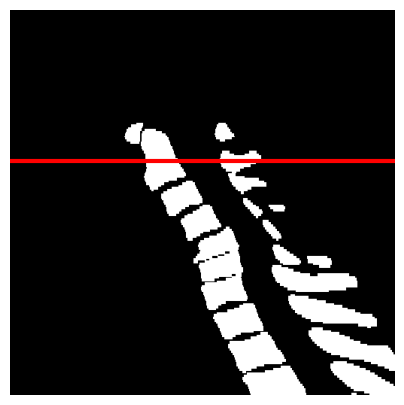

In [13]:
nii_path = '/kaggle/input/rsna-2022-cervical-spine-fracture-detection/segmentations/1.2.826.0.1.3680043.10633.nii'
mask = load_nii('1.2.826.0.1.3680043.10633', nii_path, 3)
length = len(mask)//2
index = 200
vert_list = np.unique(mask[length][index, :])/255

if len(vert_list) > 1: print(vert_list[len(vert_list)-2:])
else: print(vert_list)
plt.figure(figsize=(5, 5))
plt.plot([0, 512], [index, index], color='red', linewidth=3)
plt.imshow(mask[length])
plt.axis('off')
plt.show()

del(mask)

[2. 3.]


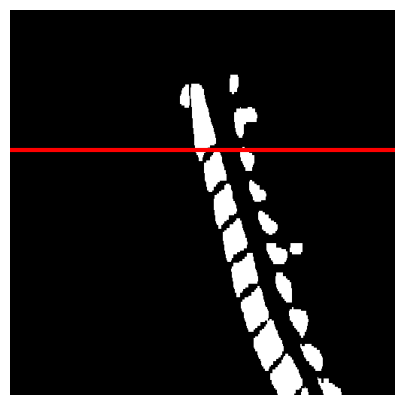

In [14]:
nii_path = '/kaggle/input/rsna-2022-cervical-spine-fracture-detection/segmentations/1.2.826.0.1.3680043.1363.nii'
dcm_path = glob('/kaggle/input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.1363/*.dcm')
mask = load_nii('1.2.826.0.1.3680043.1363', nii_path, 3)
maskid_list = sorted(dcm_path, key=lambda p: int(os.path.splitext(os.path.basename(p))[0]))

for idx, maskid in enumerate(maskid_list):
    maskid_list[idx] = int(maskid.split('/')[-1].split('.')[0])

index = 126
length = len(mask)//2
real_idx = len(maskid_list) - 1 - index
idx_list = NormalizeData(maskid_list) * 512
vert_list = np.unique(mask[length][round(idx_list[real_idx]), :])/255

if len(vert_list) > 1: print(vert_list[len(vert_list)-2:])
else: print(vert_list)
plt.figure(figsize=(5, 5))
plt.plot([0, 512], [round(idx_list[real_idx]), round(idx_list[real_idx])], color='red', linewidth=3)
plt.imshow(mask[length])
plt.axis('off')
plt.show()

del(mask)

## test on printing images

In [15]:
UID = '1.2.826.0.1.3680043.1363'
path_train = glob(f'{train_path}/{UID}/*')
path_seg = f'{segmentation_path}/{UID}.nii'

# convert train images
image, ImagePositionPatient_z, PatientUID = load_dicom(UID, path_train)
# convert segmentation images
masks = load_nii(UID, path_seg, 3) # channel 3 to test printing

(199, 512, 512, 3)


(-0.5, 511.5, 511.5, -0.5)

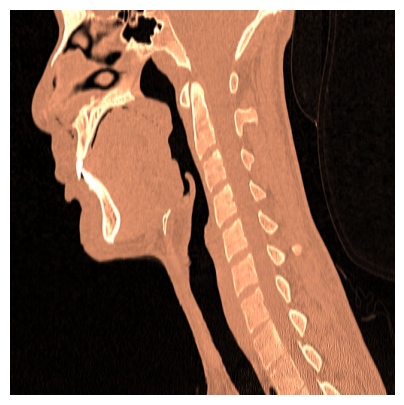

In [16]:
print(image.shape)
new_image = image[:, ::-1, ::-1, :].transpose(1, 2, 0, 3)
print_image = new_image[:, new_image.shape[1]//2, :]
rot_image = cv2.rotate(print_image, cv2.ROTATE_180)
rot_image = cv2.rotate(rot_image, cv2.ROTATE_90_CLOCKWISE)
rot_image = cv2.flip(rot_image, 1)
if UID not in seg_revert:
    rot_image = cv2.flip(rot_image, 0)
rot_image = cv2.resize(rot_image, (512, 512))
    
plt.figure(figsize=(5, 5))
plt.imshow(rot_image)
plt.axis('off')

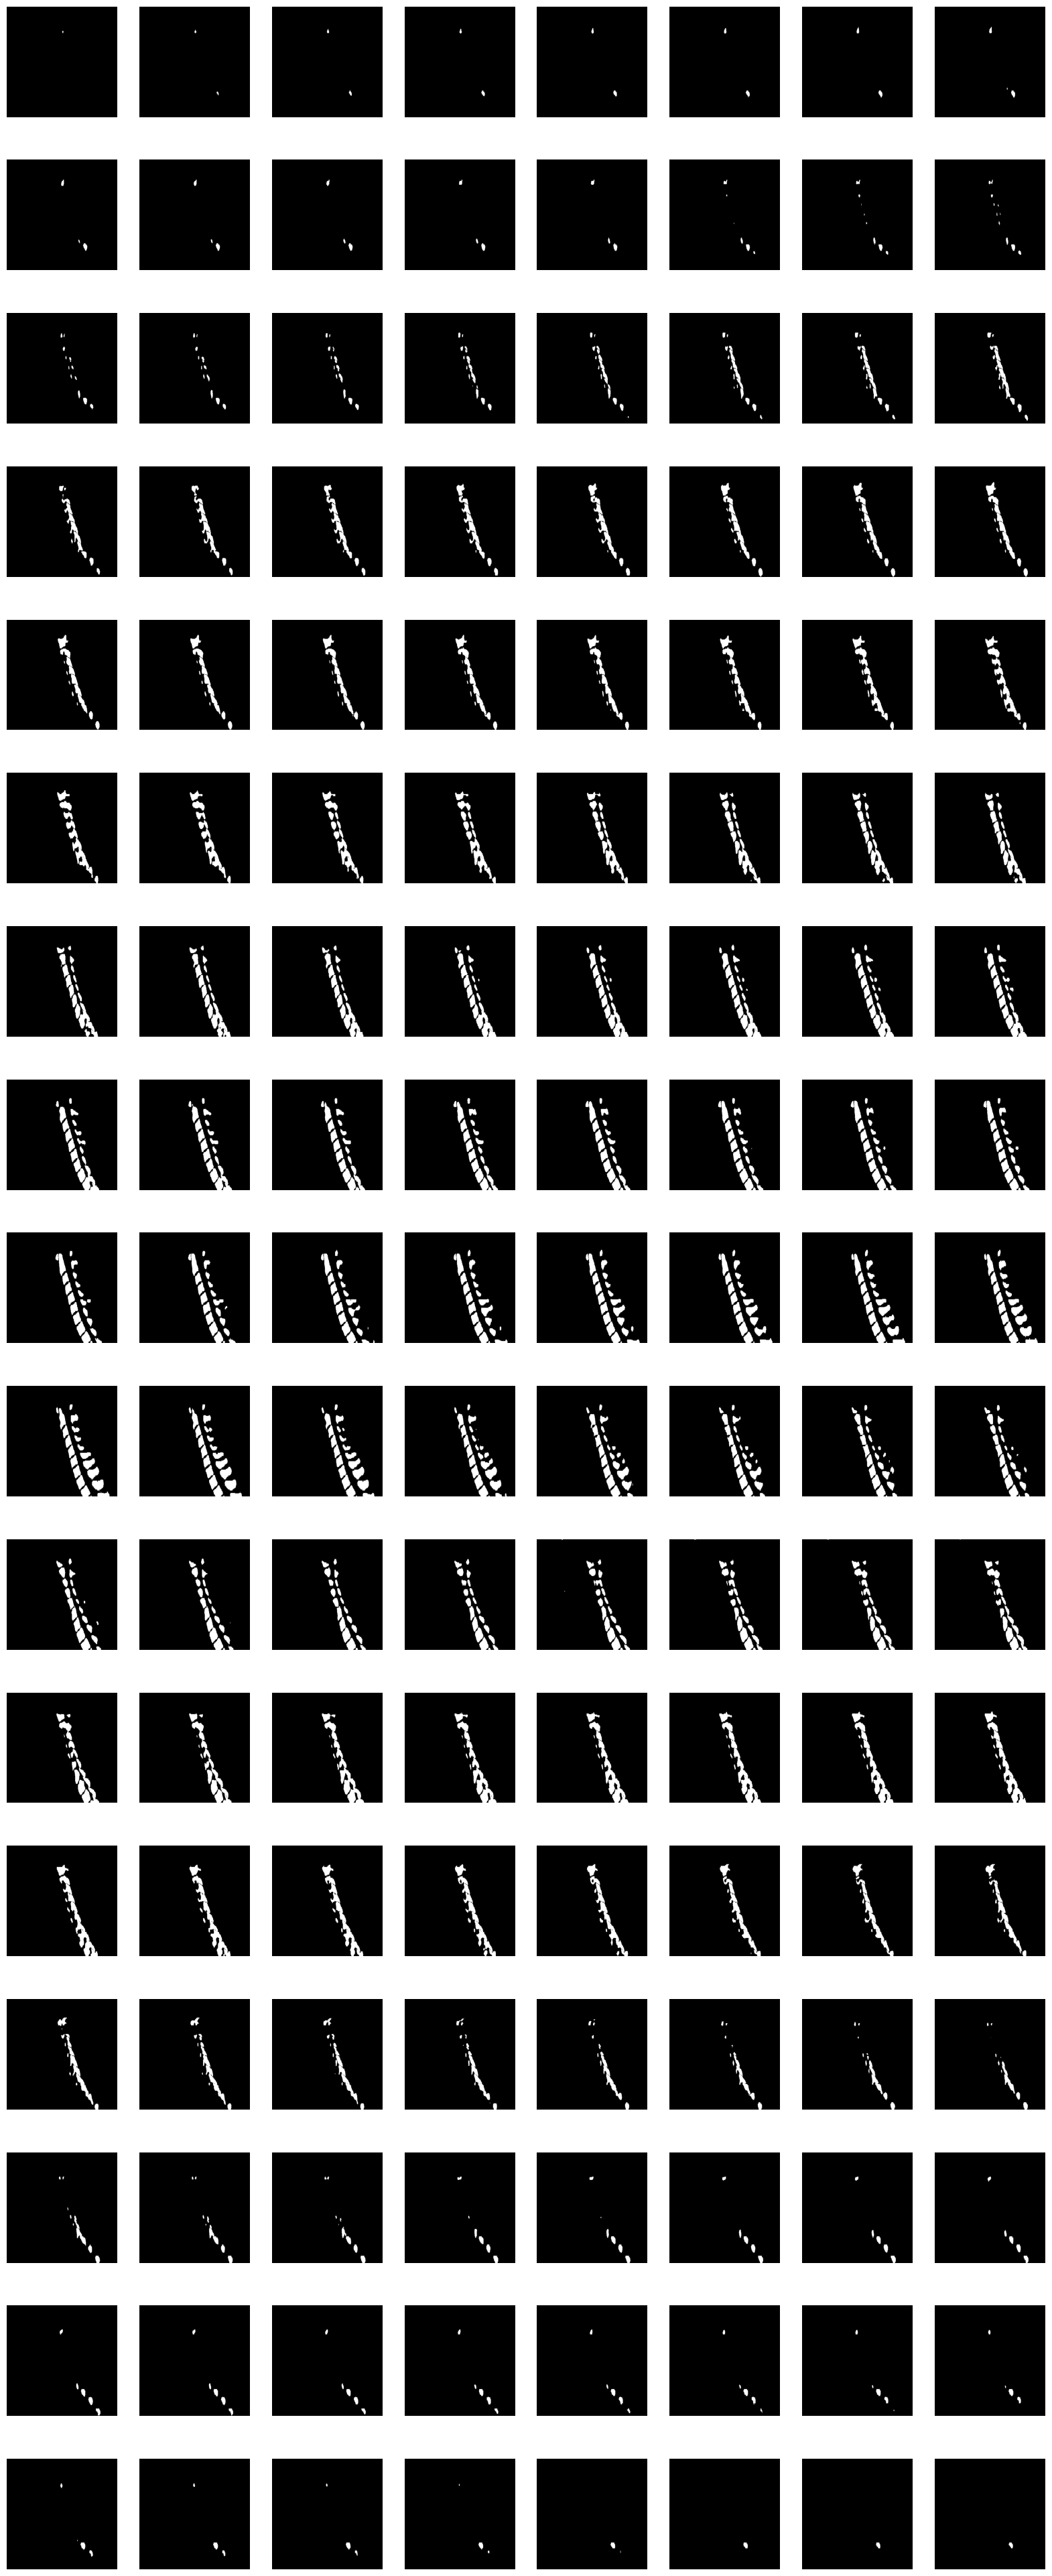

In [17]:
new_masks = []
for mask in masks:
    if len(np.unique(mask)) > 1:
        new_masks.append(mask)
        
row = len(new_masks)//8
plt.subplots(row, 8, figsize=(20, 50))
for num, mask in enumerate(new_masks):
    if (num+1 <= row*8):
        plt.subplot(row, 8, num+1)
        plt.imshow(mask)
        plt.axis('off')

[1. 3.]


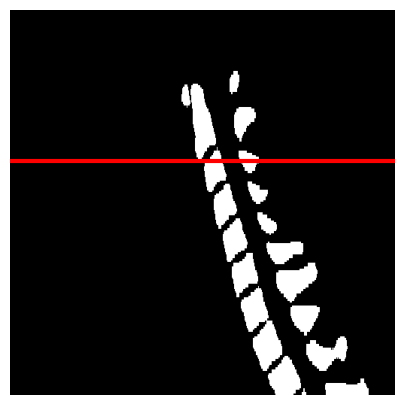

In [18]:
length = len(new_masks)//2
index = 200
vert_list = np.unique(new_masks[length][index, :])/255

if len(vert_list) > 1: print(vert_list[len(vert_list)-2:])
else: print(vert_list)
plt.figure(figsize=(5, 5))
plt.plot([0, 512], [index, index], color='red', linewidth=3)
plt.imshow(new_masks[length])
plt.axis('off')
plt.show()

del(new_masks)

## preprocessing

In [19]:
studyuid_list = []
mask_vert = []

# images are loaded from C7 to C1.
# it is evident from the axial images that index 120 displays the jaws
# and 200 has ears in it
for idx in tqdm(range(len(df_seg))):
    df = df_seg.iloc[idx]
    uid = df['StudyInstanceUID']
    img = df['image_folder']
    image_path = glob(f'{img}/*.dcm')
    mask_path = df['mask_file']

    image, ImagePositionPatient_z, PatientUID = load_dicom(uid, image_path)
    mask = load_nii(uid, mask_path)
    
    new_masks = []
    for each_mask in mask:
        if len(np.unique(each_mask)) > 1:
            new_masks.append(each_mask)
    length = len(new_masks)//2
    
    # width, height, depth, channel
    new_image = image[:, ::-1, ::-1, :].transpose(1, 2, 0, 3)
    data = NormalizeData(list(ImagePositionPatient_z))*511
    
    for index in range(len(PatientUID)):
        id_index = round(data[index])
        uid_id = PatientUID[index]
        
        if uid in seg_revert:
            id_index = round(data[len(PatientUID)-index-1])
            vert = mode(new_masks[length][id_index, :])
        else:
            vert = mode(new_masks[length][id_index, :])
            
        studyuid_list.append(uid_id)
        mask_vert.append(vert)
    
    del(image)
    del(mask)
    del(ImagePositionPatient_z)
    del(PatientUID)
    del(new_masks)
    del(new_image)
    del(each_mask)

  0%|          | 0/87 [00:00<?, ?it/s]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550]


  1%|          | 1/87 [01:07<1:37:22, 67.94s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805 3315]


  2%|▏         | 2/87 [02:20<1:40:23, 70.86s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550]


  3%|▎         | 3/87 [03:33<1:40:07, 71.52s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805 3060]


  5%|▍         | 4/87 [05:26<2:01:50, 88.07s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805]


  6%|▌         | 5/87 [06:40<1:53:24, 82.98s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550]


  7%|▋         | 6/87 [08:06<1:53:17, 83.92s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550]


  8%|▊         | 7/87 [09:20<1:47:43, 80.80s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805]


  9%|▉         | 8/87 [10:47<1:49:02, 82.82s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550]


 10%|█         | 9/87 [12:05<1:45:44, 81.33s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805]


 11%|█▏        | 10/87 [13:27<1:44:24, 81.35s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550]


 13%|█▎        | 11/87 [14:41<1:40:07, 79.05s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 3315]


 14%|█▍        | 12/87 [16:04<1:40:34, 80.47s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550]


 15%|█▍        | 13/87 [17:16<1:35:54, 77.77s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805 3060 3315]


 16%|█▌        | 14/87 [18:25<1:31:36, 75.29s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805]


 17%|█▋        | 15/87 [19:56<1:36:00, 80.01s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550]


 18%|█▊        | 16/87 [21:07<1:31:28, 77.30s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550]


 20%|█▉        | 17/87 [22:51<1:39:33, 85.33s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805]


 21%|██        | 18/87 [24:05<1:34:00, 81.75s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550]


 22%|██▏       | 19/87 [25:12<1:27:50, 77.51s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550]


 23%|██▎       | 20/87 [26:27<1:25:25, 76.50s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550]


 24%|██▍       | 21/87 [27:57<1:28:48, 80.74s/it]

[   0  255  510  765 1020 1275 1530 1785 2040]


 25%|██▌       | 22/87 [29:10<1:24:49, 78.30s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550]


 26%|██▋       | 23/87 [30:23<1:21:57, 76.84s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295]


 28%|██▊       | 24/87 [31:32<1:18:03, 74.34s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550]


 29%|██▊       | 25/87 [32:43<1:15:55, 73.48s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805]


 30%|██▉       | 26/87 [34:20<1:21:52, 80.54s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805 3060 3315
 3570]


 31%|███       | 27/87 [35:39<1:19:57, 79.96s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805]


 32%|███▏      | 28/87 [36:50<1:16:00, 77.30s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550]


 33%|███▎      | 29/87 [38:09<1:15:18, 77.90s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550]


 34%|███▍      | 30/87 [39:35<1:16:18, 80.33s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550]


 36%|███▌      | 31/87 [40:46<1:12:16, 77.44s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550]


 37%|███▋      | 32/87 [42:19<1:15:14, 82.07s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550]


 38%|███▊      | 33/87 [43:55<1:17:34, 86.20s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550]


 39%|███▉      | 34/87 [45:04<1:11:43, 81.19s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550]


 40%|████      | 35/87 [46:33<1:12:28, 83.63s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805 3060]
[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805 3315 3570]


 43%|████▎     | 37/87 [49:00<1:04:58, 77.97s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550]


 44%|████▎     | 38/87 [50:23<1:04:52, 79.44s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805]


 45%|████▍     | 39/87 [51:34<1:01:38, 77.06s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805]


 46%|████▌     | 40/87 [53:04<1:03:22, 80.91s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550]


 47%|████▋     | 41/87 [54:19<1:00:42, 79.18s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550]


 48%|████▊     | 42/87 [55:44<1:00:37, 80.84s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805 3060]


 49%|████▉     | 43/87 [56:56<57:23, 78.26s/it]  

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550]


 51%|█████     | 44/87 [58:06<54:19, 75.80s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805 3060 3315]


 52%|█████▏    | 45/87 [59:33<55:24, 79.16s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805]


 53%|█████▎    | 46/87 [1:00:49<53:20, 78.05s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550]


 54%|█████▍    | 47/87 [1:02:00<50:34, 75.85s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550]


 55%|█████▌    | 48/87 [1:03:22<50:38, 77.91s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805]


 56%|█████▋    | 49/87 [1:04:40<49:13, 77.73s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 3060]


 57%|█████▋    | 50/87 [1:06:24<52:49, 85.67s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295]


 59%|█████▊    | 51/87 [1:07:46<50:41, 84.48s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550]


 60%|█████▉    | 52/87 [1:09:22<51:27, 88.21s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550]


 61%|██████    | 53/87 [1:10:31<46:40, 82.36s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295]


 62%|██████▏   | 54/87 [1:11:39<42:58, 78.14s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550]


 63%|██████▎   | 55/87 [1:13:04<42:38, 79.96s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295]


 64%|██████▍   | 56/87 [1:14:18<40:24, 78.21s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550]


 66%|██████▌   | 57/87 [1:15:29<38:00, 76.01s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550]


 67%|██████▋   | 58/87 [1:16:40<36:00, 74.50s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805]


 68%|██████▊   | 59/87 [1:17:49<34:03, 73.00s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805 3060 3315]


 69%|██████▉   | 60/87 [1:19:20<35:12, 78.23s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805]


 70%|███████   | 61/87 [1:20:50<35:26, 81.79s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550]


 71%|███████▏  | 62/87 [1:22:04<33:07, 79.50s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805]


 72%|███████▏  | 63/87 [1:23:12<30:24, 76.03s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805]


 74%|███████▎  | 64/87 [1:24:36<30:04, 78.44s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805]


 75%|███████▍  | 65/87 [1:25:48<28:04, 76.58s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805]


 76%|███████▌  | 66/87 [1:27:11<27:29, 78.55s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805 3060 3315]


 77%|███████▋  | 67/87 [1:28:23<25:28, 76.42s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805]


 78%|███████▊  | 68/87 [1:29:39<24:09, 76.30s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805 3060]


 79%|███████▉  | 69/87 [1:31:05<23:45, 79.17s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295]


 80%|████████  | 70/87 [1:32:28<22:46, 80.36s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805]


 82%|████████▏ | 71/87 [1:33:43<21:01, 78.82s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550]


 83%|████████▎ | 72/87 [1:35:01<19:41, 78.75s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805]


 84%|████████▍ | 73/87 [1:36:22<18:28, 79.19s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805 3060]


 85%|████████▌ | 74/87 [1:37:34<16:44, 77.23s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805]


 86%|████████▌ | 75/87 [1:38:47<15:11, 75.94s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550]


 87%|████████▋ | 76/87 [1:40:26<15:09, 82.69s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550]


 89%|████████▊ | 77/87 [1:41:38<13:15, 79.51s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805]


 90%|████████▉ | 78/87 [1:42:49<11:33, 77.11s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805 3060 3315]


 91%|█████████ | 79/87 [1:44:05<10:14, 76.79s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805]


 92%|█████████▏| 80/87 [1:45:20<08:53, 76.25s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805]


 93%|█████████▎| 81/87 [1:47:00<08:19, 83.32s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805 3060 3315]


 94%|█████████▍| 82/87 [1:48:14<06:42, 80.42s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550]


 95%|█████████▌| 83/87 [1:49:25<05:11, 77.79s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805 3060]


 98%|█████████▊| 85/87 [1:52:16<02:45, 82.77s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805]


 99%|█████████▉| 86/87 [1:53:43<01:24, 84.16s/it]

[   0  255  510  765 1020 1275 1530 1785 2040 2295 2550 2805]


100%|██████████| 87/87 [1:54:55<00:00, 79.25s/it]


In [20]:
df_save = pd.DataFrame(list(zip(studyuid_list, mask_vert)), columns=['id', 'vertebrae'])
df_save.to_csv('vert_list.csv', index=False)

In [21]:
os.rmdir('/kaggle/working/train_images')
os.rmdir('/kaggle/working/segmentations')